<a href="https://colab.research.google.com/github/GIGAParviz/Lip-Reading-/blob/main/Lip_Reading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
import gdown
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From: https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
To: /content/data.zip
100%|██████████| 423M/423M [00:04<00:00, 104MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
vocab

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = './data/s1/bbal6n.mpg'
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))


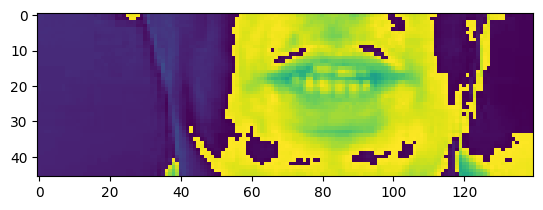

In [ ]:
plt.imshow(frames[40])


In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [ ]:
from matplotlib import pyplot as plt
data = tf.data.Dataset.list_files('/content/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [ ]:
len(train
)

450

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
sample

In [ ]:
val = sample.next(); val[0]

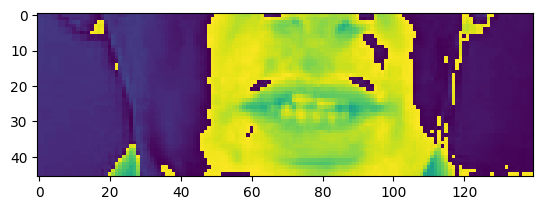

In [ ]:
plt.imshow(val[0][1][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin white with n seven soon'>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 75, 23, 70, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                      

In [ ]:
import tensorflow as tf
from tensorflow import keras

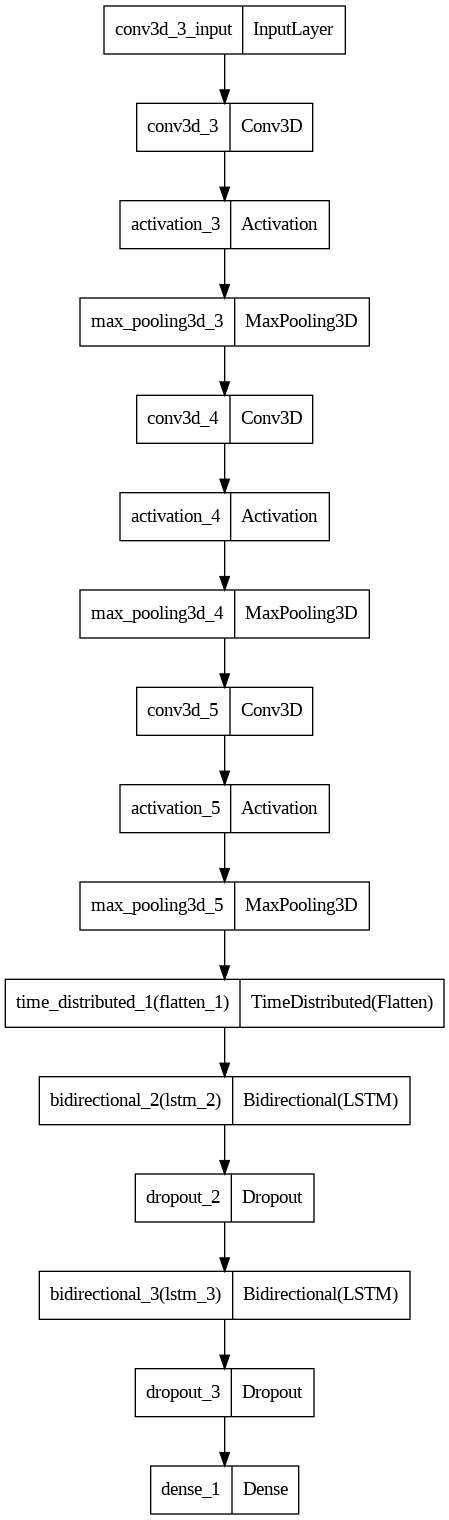

In [ ]:
keras.utils.plot_model(model)

In [ ]:
yhat = model.predict(val[0])


1/1 [==============================] - 9s 9s/step


In [ ]:
yhat

array([[[0.023477  , 0.01972037, 0.02991942, ..., 0.03019698,
         0.02650131, 0.02317179],
        [0.02259527, 0.01935102, 0.03047962, ..., 0.03093099,
         0.02696701, 0.02277003],
        [0.02209558, 0.01915876, 0.03080808, ..., 0.03213139,
         0.02721296, 0.02235265],
        ...,
        [0.02109055, 0.02077763, 0.02954616, ..., 0.03419327,
         0.02132239, 0.02078096],
        [0.02146365, 0.02207047, 0.0283673 , ..., 0.03320159,
         0.0212568 , 0.02112074],
        [0.02185753, 0.02336649, 0.02719181, ..., 0.03187159,
         0.02160368, 0.02161161]],

       [[0.0218101 , 0.02019904, 0.03044686, ..., 0.0295702 ,
         0.0250998 , 0.02409123],
        [0.02085663, 0.02001645, 0.03046969, ..., 0.0303253 ,
         0.02565141, 0.0237017 ],
        [0.02029196, 0.01996637, 0.03053702, ..., 0.03155737,
         0.02592803, 0.02318808],
        ...,
        [0.01962109, 0.02294579, 0.02818825, ..., 0.03226327,
         0.02132246, 0.02218728],
        [0.0

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=50, callbacks=[checkpoint_callback, schedule_callback]) #, example_callback

Epoch 1/50
450/450 [==============================] - 694s 2s/step - loss: 54.3347 - val_loss: 49.8742 - lr: 1.0000e-04
Epoch 2/50
450/450 [==============================] - 674s 1s/step - loss: 52.4212 - val_loss: 47.5493 - lr: 1.0000e-04
Epoch 3/50
450/450 [==============================] - 667s 1s/step - loss: 50.4139 - val_loss: 45.8626 - lr: 1.0000e-04
Epoch 4/50
450/450 [==============================] - 666s 1s/step - loss: 48.1352 - val_loss: 41.9049 - lr: 1.0000e-04
Epoch 5/50
450/450 [==============================] - 661s 1s/step - loss: 45.5958 - val_loss: 41.8115 - lr: 1.0000e-04
Epoch 6/50
450/450 [==============================] - 660s 1s/step - loss: 43.1029 - val_loss: 36.7298 - lr: 1.0000e-04
Epoch 7/50
450/450 [==============================] - 658s 1s/step - loss: 40.6853 - val_loss: 35.8504 - lr: 1.0000e-04
Epoch 8/50
450/450 [==============================] - 652s 1s/step - loss: 38.4186 - val_loss: 33.7016 - lr: 1.0000e-04
Epoch 9/50
450/450 [====================

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From: https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:01<00:00, 54.5MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [ ]:
model.load_weights('/content/models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

1/1 [==============================] - 0s 278ms/step


In [ ]:
sample = test_data.next()
yhat = model.predict(sample[0])

1/1 [==============================] - 0s 268ms/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'set red with o seven soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at s one soon'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'pla re e '>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'pla re e '>]

In [ ]:
sample = load_data(tf.convert_to_tensor('content/data/s1/bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 0s 115ms/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'pla re e '>]

In [ ]:
model.save('lip_reading.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
